In [1]:
!pip install torch torchvision --quiet


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from PIL import Image

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.models import resnet50, ResNet50_Weights

from sklearn.manifold import TSNE
import torch.nn.functional as F

In [15]:
from google.colab import drive
drive.mount('/content/drive')

OUTPUT_DIR = "/content/drive/MyDrive/DSAN6700_Project/outputs_fashion_mnist"
os.makedirs(OUTPUT_DIR, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# resnet-50 default
IMAGE_SIZE = 224

preprocess = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(
    # imagenet stats
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])


In [5]:
DATA_ROOT = "/content/data_fashion_mnist"
os.makedirs(DATA_ROOT, exist_ok=True)

train_dataset = datasets.FashionMNIST(
    root=DATA_ROOT,
    train=True,
    download=True,
    transform=preprocess,
)

class_names = train_dataset.classes

# some checks
print("Classes:", class_names)
print("Total train images:", len(train_dataset))


100%|██████████| 26.4M/26.4M [00:00<00:00, 107MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 4.11MB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 58.4MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 14.4MB/s]


Classes: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Total train images: 60000


In [6]:
BATCH_SIZE = 128

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
)

len(train_loader)


469

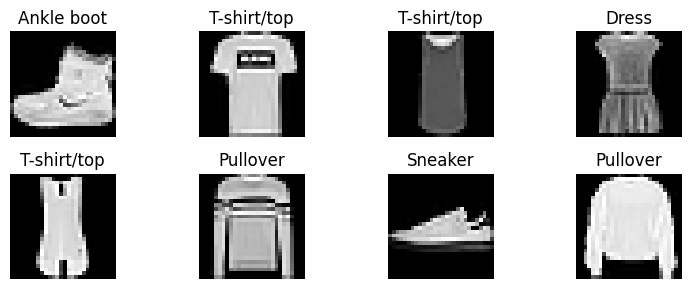

In [7]:
# randome un-transformed images
raw_dataset = datasets.FashionMNIST(
    root=DATA_ROOT,
    train=True,
    download=True,
    transform=None,
)

plt.figure(figsize=(8, 3))
for i in range(8):
    img, label = raw_dataset[i]
    plt.subplot(2, 4, i+1)
    plt.imshow(img, cmap="gray")
    plt.title(class_names[label])
    plt.axis("off")
plt.tight_layout()
plt.show()


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# load a ResNet-50 model pre-trained on Imagenet
weights = ResNet50_Weights.IMAGENET1K_V2
# ImageNet weights for this architecture
resnet = resnet50(weights=weights)

"""
We want to use ResNet as a *feature extractor*, not as a classifier.
The original ResNet-50 ends with a fully connected (fc) layer that
maps 2048 features -> 1000 ImageNet classes.
Here, we remove that final fc layer and keep everything up to the
global average pooling layer so we get a 2048-dim embedding for each image.
"""
feature_extractor = torch.nn.Sequential(*list(resnet.children())[:-1])

# move the feature extractor to the selected device
feature_extractor = feature_extractor.to(device)
feature_extractor.eval()


Using device: cuda
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 246MB/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [11]:
@torch.no_grad()
def extract_embeddings_batch(images: torch.Tensor) -> torch.Tensor:
    """
    Compute L2-normalized embeddings for a batch of images.

    Args:
        images: Tensor of shape (B, 3, H, W)
                B = batch size, 3 channels (RGB), HxW spatial size.

    Returns:
        Tensor of shape (B, D), where D is the embedding dimension (2048 for ResNet-50),
        moved back to CPU and L2-normalized along the feature dimension.
    """
    images = images.to(device)
    # forward pass
    feats = feature_extractor(images) # (B, 2048, 1, 1)
    # flatten the spatial dims to get a 2d tensor
    feats = feats.view(feats.size(0), -1) # (B, 2048)
    # normalize each embedding vector along the feature dim.
    feats = F.normalize(feats, p=2, dim=1)
    return feats.cpu()


In [12]:
all_embeddings = []
all_labels = []

# loop over the DataLoader to process the dataset in batches
for images, labels in tqdm(train_loader, desc="Embedding train set"):
  # get L2-normalized embeddings for this batch of images
    emb = extract_embeddings_batch(images)
    # convert from torch tensor to numpy array
    all_embeddings.append(emb.numpy())
    all_labels.append(labels.numpy())

all_embeddings = np.vstack(all_embeddings) # (N, 2048)
all_labels = np.concatenate(all_labels) # (N,)

# some checks
print("Embeddings shape:", all_embeddings.shape)
print("Labels shape:", all_labels.shape)


Embedding train set: 100%|██████████| 469/469 [02:52<00:00,  2.71it/s]


Embeddings shape: (60000, 2048)
Labels shape: (60000,)


In [16]:
emb_path = os.path.join(OUTPUT_DIR, "fashion_mnist_resnet50_embeddings.npy")
labels_path = os.path.join(OUTPUT_DIR, "fashion_mnist_labels.npy")
classes_path = os.path.join(OUTPUT_DIR, "fashion_mnist_classes.txt")

# sasve the embeddings and labels as .npy files
np.save(emb_path, all_embeddings)
np.save(labels_path, all_labels)

# save class names
with open(classes_path, "w") as f:
    for cname in class_names:
        f.write(cname + "\n")

print("Saved embeddings to", emb_path)
print("Saved labels to", labels_path)
print("Saved classes to", classes_path)


Saved embeddings to /content/drive/MyDrive/DSAN6700_Project/outputs_fashion_mnist/fashion_mnist_resnet50_embeddings.npy
Saved labels to /content/drive/MyDrive/DSAN6700_Project/outputs_fashion_mnist/fashion_mnist_labels.npy
Saved classes to /content/drive/MyDrive/DSAN6700_Project/outputs_fashion_mnist/fashion_mnist_classes.txt


In [17]:
# randomly sample out 2000 points for t-sne viz
N_SUB = min(2000, all_embeddings.shape[0])
idx = np.random.choice(all_embeddings.shape[0], size=N_SUB, replace=False)

emb_sample = all_embeddings[idx]
labels_sample = all_labels[idx]

# set up t-SNE model
tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    random_state=42,
    init="random",
    n_iter=1000,
    verbose=1,
)

emb_2d = tsne.fit_transform(emb_sample)

print("t-SNE output shape:", emb_2d.shape)


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.002s...
[t-SNE] Computed neighbors for 2000 samples in 0.333s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.186450
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.966568
[t-SNE] KL divergence after 1000 iterations: 1.108309
t-SNE output shape: (2000, 2)


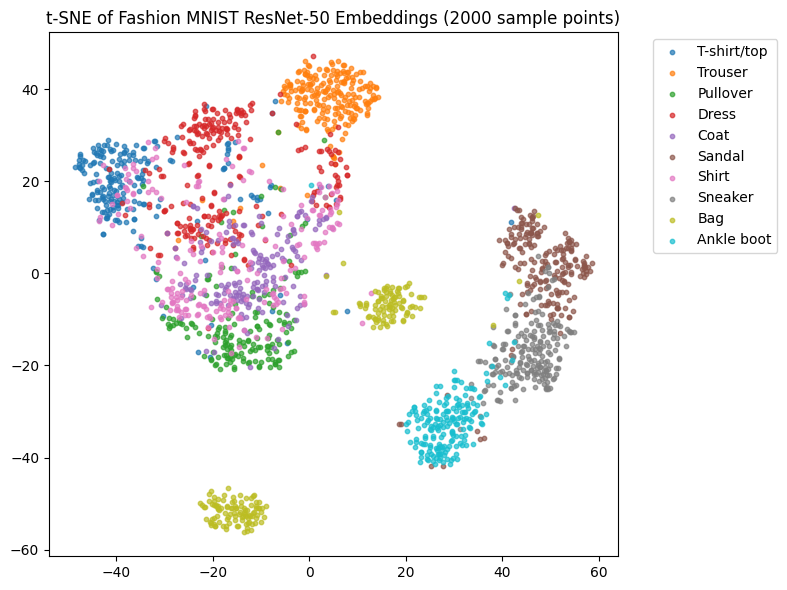

In [18]:
plt.figure(figsize=(8, 6))

for class_idx, class_name in enumerate(class_names):
    mask = labels_sample == class_idx
    if not np.any(mask):
        continue
    plt.scatter(
        emb_2d[mask, 0],
        emb_2d[mask, 1],
        s=10,
        alpha=0.7,
        label=class_name,
    )

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("t-SNE of Fashion MNIST ResNet-50 Embeddings (2000 sample points)")
plt.tight_layout()

plt.show()


In [19]:
from torchvision import transforms as T

# Reuse same preprocess BUT for PIL inputs
image_preprocess = preprocess

@torch.no_grad()
def get_embedding_for_pil(img: Image.Image) -> np.ndarray:
    """
    Input: PIL image (grayscale or RGB)
    Output: 1D embedding (2048,)
    """
    img = img.convert("L")  # ensure grayscale like Fashion MNIST
    x = image_preprocess(img).unsqueeze(0) # (1, 3, H, W)
    emb = extract_embeddings_batch(x) # (1, 2048)
    return emb.numpy().reshape(-1)


In [23]:
test_img, test_label = raw_dataset[6700]
print("Label:", class_names[test_label])

emb_vec = get_embedding_for_pil(test_img)
print("Embedding shape:", emb_vec.shape)


Label: Ankle boot
Embedding shape: (2048,)
